So, unfortunately we've found out that `qml.QubitUnitary` by itself is not entirely differentiable and we would have to use the Jacobian w.r.t. each unitary entry to manually do an update. This is going to be very slow and unoptimized.

Instead, the plan is to currently work on chi = 2 MPS, which is only mapped to two-qubit unitaries and use exisitng decomposition in qml (KAK decomposition with a fixed template) to turn that into trainable gates and parameters. The problem is that this needs to be done for all the gates in the circuit **(some sort of a transform)**.

Plan and steps:

Goal : Map the chi = 2 MPS to a trainable PQC (without any extending gates) and further train the parameters

Steps:
- Extract the list of unitaries from the MPS
- Construct the simplest circuit with `qml.QubitUnitary` gates
- Apply the `qml.transforms.unitary_to_rot` to construct the KAK-decomposed circuit
- Train the newly constructed circuit

In [1]:
cd ..

/home/abhishekabhishek/git/UnsupGenModbyMPS


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
from jax import numpy as jnp

from MPScumulant import MPS_c
import mps_circuit_helpers as helpers
import mps_circuit
import metrics

%load_ext autoreload

Step 1 : Extract the list of MPS unitaries

In [3]:
# load and format the data
data = np.load('BStest/BSdata.npy')
data_states = data.reshape(-1, 16).astype(np.int8)

In [4]:
%autoreload
m = MPS_c(16, max_bond_dim=2)
m.loadMPS('BS-2-MPS')

# check the properties of the matrices in the MPS
for i in range(len(m.matrices)):
    tn_core = m.matrices[i]
    print(i, tn_core.shape)

0 (1, 2, 2)
1 (2, 2, 2)
2 (2, 2, 2)
3 (2, 2, 2)
4 (2, 2, 2)
5 (2, 2, 2)
6 (2, 2, 2)
7 (2, 2, 2)
8 (2, 2, 2)
9 (2, 2, 2)
10 (2, 2, 2)
11 (2, 2, 2)
12 (2, 2, 2)
13 (2, 2, 2)
14 (2, 2, 2)
15 (2, 2, 1)


Step 2 : Construct the simplest circuit with `qml.QubitUnitary`

In [7]:
mps_unitaries = helpers.get_mps_unitaries(m)
mps_circ = mps_circuit.mps_unitaries_to_circuit(mps_unitaries)

padding the mps core tensors
idx, shape of the padded tensor, updated bond dimension
i = 1, (2, 2, 2), 2
i = 2, (2, 2, 2), 2
i = 3, (2, 2, 2), 2
i = 4, (2, 2, 2), 2
i = 5, (2, 2, 2), 2
i = 6, (2, 2, 2), 2
i = 7, (2, 2, 2), 2
i = 8, (2, 2, 2), 2
i = 9, (2, 2, 2), 2
i = 10, (2, 2, 2), 2
i = 11, (2, 2, 2), 2
i = 12, (2, 2, 2), 2
i = 13, (2, 2, 2), 2
i = 14, (2, 2, 2), 2
left canonicalizing the padded MPS
bond: 0
bond: 1
bond: 2
bond: 3
bond: 4
bond: 5
bond: 6
bond: 7
bond: 8
bond: 9
bond: 10
bond: 11
bond: 12
bond: 13
bond: 14


(<Figure size 1368x1224 with 1 Axes>, <Axes: >)

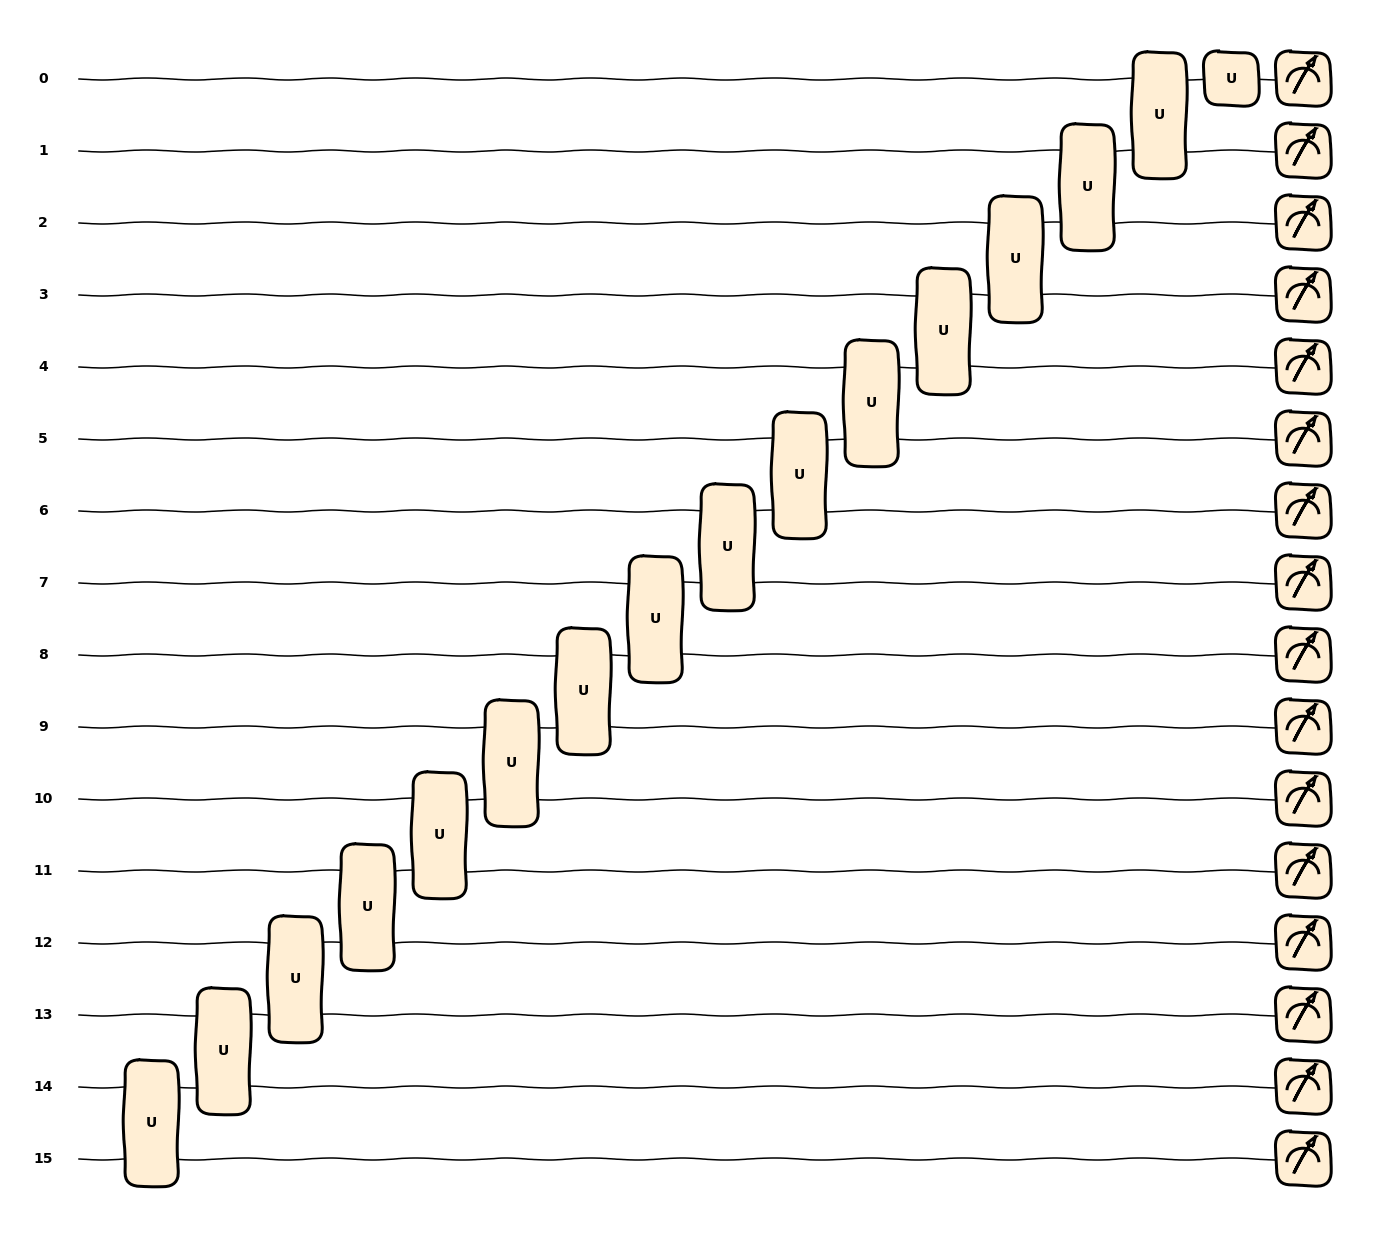

In [8]:
qml.drawer.draw_mpl(mps_circ, style="sketch")()

Step 3 : Apply the `qml.transforms.unitary_to_rot` to construct the KAK-decomposed circuit

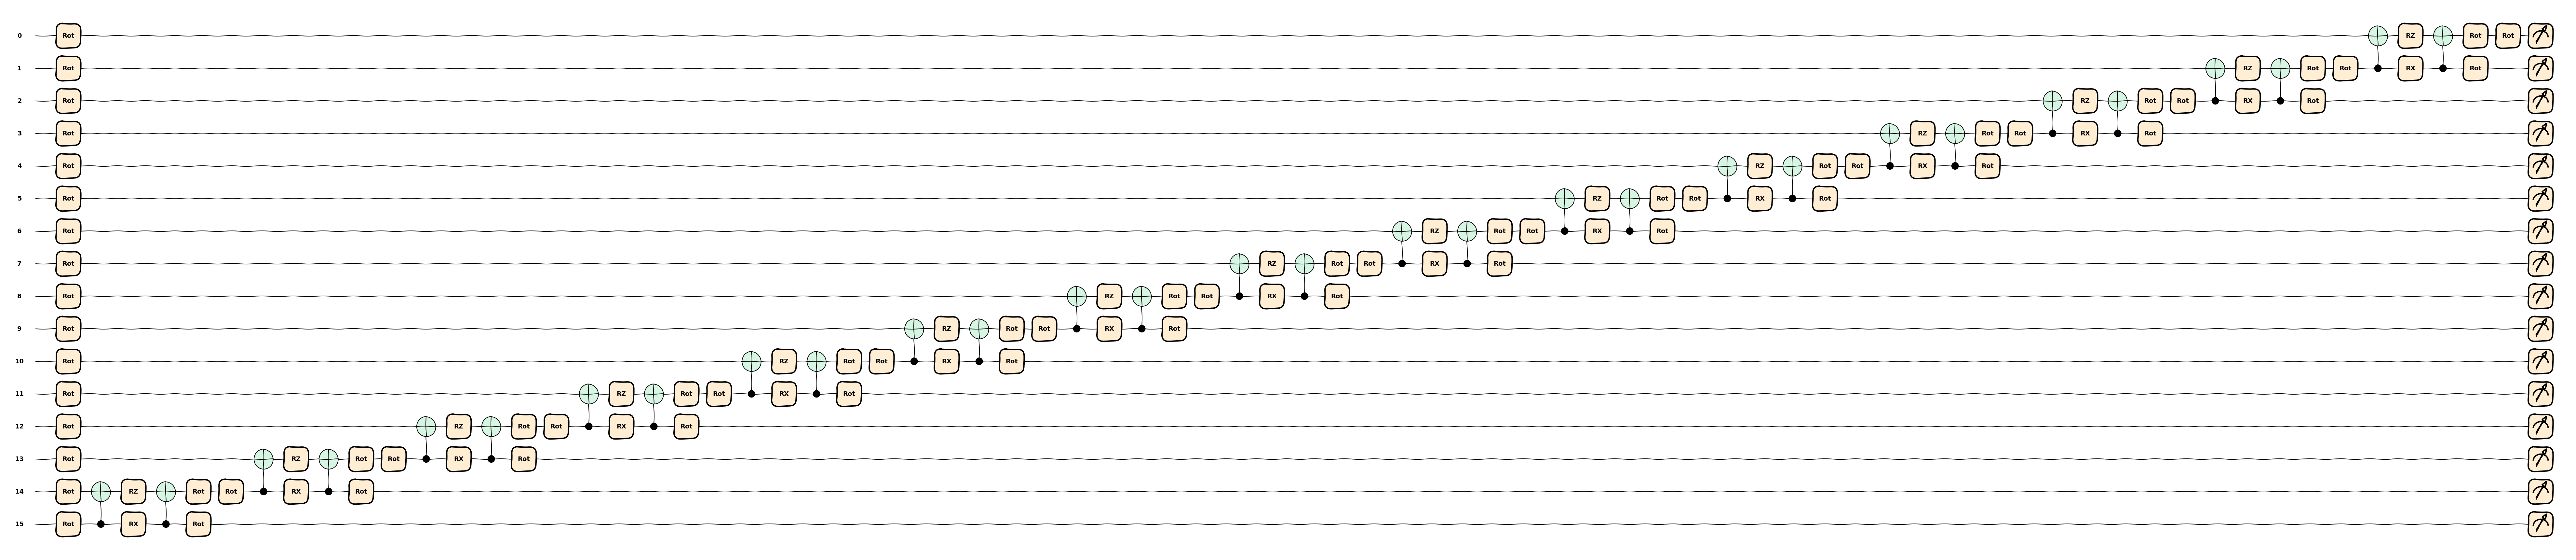

In [19]:
expanded_tape = qml.transforms.unitary_to_rot.tape_fn(mps_circ._tape)
fig, ax = qml.drawer.tape_mpl(expanded_tape, style='sketch',
                              wire_order=range(expanded_tape.num_wires))

Verify that the above decomposed circuit actually returns the same probabilities

In [21]:
# define if using sampler vs analytic qnode, use shots=None for analytic
shots = None
n_wires = expanded_tape.num_wires

params = jnp.array(qml.math.stack(expanded_tape.data))
dev = qml.device("default.qubit", wires=n_wires, shots=shots)

@qml.qnode(dev, interface="jax")
def expanded_circ(params):
    idx = 0
    for op in expanded_tape.operations:
        if op.num_params > 0:
            if op.name == "Rot":
                op.__class__(*params[idx:idx+3], wires=op.wires)
                idx += 3
            else:
                op.__class__(params[idx], wires=op.wires)
                idx += 1
        else:
            op.__class__(wires=op.wires)
    return qml.probs(wires=list(range(n_wires)))